## Reinforcement learning 2023
---
KHU

Deep Deterministic Policy Gradient (DDPG)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'/RL/DDPG
!ls
import sys; sys.path.append('..') # add project root to the python path

In [ ]:
!pip install swig
!pip install gym[all]
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import numpy as np
import matplotlib.pyplot as plt

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
from IPython.display import clear_output
import glob
import base64, io

# Network

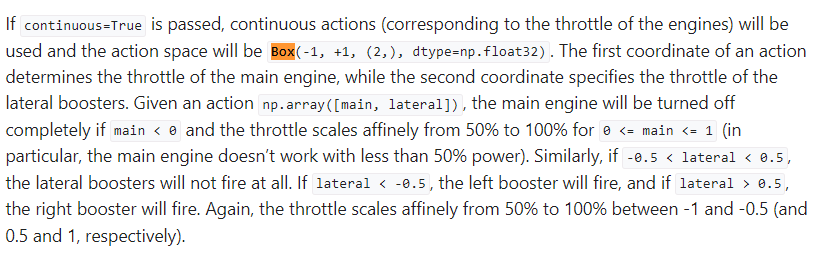

action dimension : 2

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, action_dim)   # action dimension: 2 (main engine, lateral movement)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

# In critics, Q(s,a) is input and the value is output
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.fc3 = nn.Linear(300, 1)

    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Replay Buffer

In [ ]:
class ReplayBuffer:

    def __init__(self, state_dim, action_dim, max_size=int(1e6)):
        self.s = np.zeros((max_size, state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.float32)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.ns = np.zeros((max_size, state_dim), dtype=np.float32)
        self.done = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, ns, done):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.ns[self.ptr] = ns
        self.done[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.ns[ind]),
            torch.FloatTensor(self.done[ind]),
        )

# OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference:
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [ ]:
import random
import copy

class OUNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

# DDPG

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)).

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$



### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

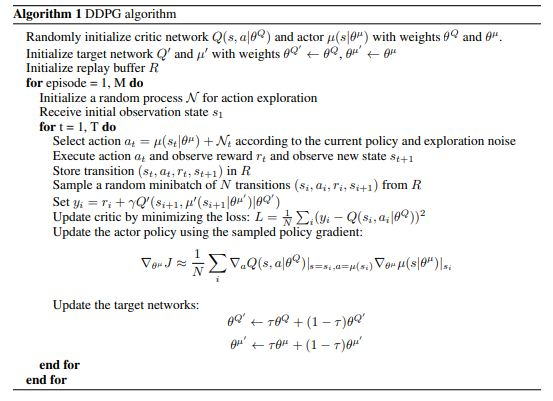

In [ ]:
class DDPG:
    def __init__(
            self,
            state_dim,
            action_dim,
            lr=0.00025,
            gamma=0.99,
            batch_size=64,
            warmup_steps=5000,
            tau=5e-3,
            buffer_size=int(1e5)
    ):
        self.action_dim = action_dim
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.tau = tau
        # noise
        self.noise = OUNoise(
          mu=np.zeros(action_dim)
        )
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

        self.actor = Actor(state_dim, action_dim).to(self.device)
        self.critic = Critic(state_dim, action_dim).to(self.device)

        self.actor_target = Actor(state_dim, action_dim).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.critic_target = Critic(state_dim, action_dim).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())

        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (2,), buffer_size)

        self.total_steps = 0

    def select_action(self, x,training=True):

        if training:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            a = self.actor(x).detach().cpu().numpy()
            a = a+self.noise()[0]
            a=np.clip(a,-1.0,1.0)

        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            a = self.actor(x).detach().cpu().numpy()

        return a[0]

    def update_model(self):

        s, a, r, ns, done = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))
        na = self.actor_target(ns)
        next_value = self.critic_target(ns, na)
        td_target = r + self.gamma * (1 - done) * next_value

        # Critic Optimiizataoin
        values = self.critic(s, a)
        critic_loss = F.mse_loss(values, td_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor Optimization
        # J = E[r(s,mu(s))] = E[Q(s,a)]
        actor_loss = -self.critic(s, self.actor(s)).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Target update
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    def process(self, transition):

        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps>self.warmup_steps:
            self.update_model()

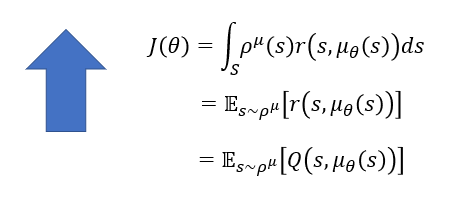

In [ ]:
env = gym.make('LunarLander-v2', continuous=True)

max_steps = int(1e6)
eval_interval = 10000
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

agent = DDPG(state_dim, action_dim)



In [ ]:
def evaluate(n_evals=1):
    eval_env = gym.make('LunarLander-v2', continuous=True)

    scores = 0
    for i in range(n_evals):
        s, done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.select_action(s,training=False)
            s_prime, r, terminated, _ = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated
        scores += ret
    return np.round(scores / n_evals, 4)

In [ ]:
history = {'Step': [], 'AvgReturn': []}
s= env.reset()
rewards=0

while True:

    if agent.total_steps < agent.warmup_steps:
        a = env.action_space.sample()
    else:
        a = agent.select_action(s,training=True)

    ns, r, done,_ = env.step(a)
    # Update
    agent.process((s, a, r, ns, done))
    s = ns
    rewards+=r
    if done  or rewards<-250:
        s = env.reset()
        rewards=0

    if agent.total_steps % eval_interval == 0:
        avgreturn = evaluate()
        history['Step'].append(agent.total_steps)
        history['AvgReturn'].append(avgreturn)

        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()

        if 200 < avgreturn:
            torch.save(agent.actor.state_dict(), 'ddpg.pt')

    if agent.total_steps > max_steps:
        break

# Visualize

In [ ]:
!mkdir video
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(agent, env_name):


      env = gym.make(env_name,continuous=True)
      vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
      agent.actor.load_state_dict(torch.load('ddpg.pt'))
      s = env.reset()
      done = False
      while not done:
          frame = env.render(mode='rgb_array')
          vid.capture_frame()
          a = agent.select_action(s,training=False)
          ns, r, done, _ = env.step(a)
          s=ns

      env.close()


In [ ]:
show_video_of_model(agent, 'LunarLander-v2')

In [ ]:
show_video('LunarLander-v2')